In [1]:
# !pip install -q -U tensorflow>=1.8.0

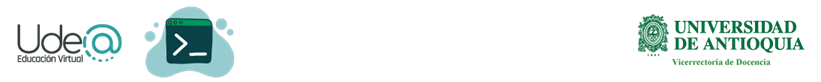

<h1><center>Road Sign Detection

Daniel Felipe Munoz Restrepo

Martin Alirio Barbosa Garzon 

Junio 2023

</center></h1>

# Introducción

En la presente seccion entrenaremos un modelo de detección de señales de tráfico utilizando el conjunto de datos "Road Sign Detection" de Kaggle. El objetivo era clasificar correctamente las diferentes señales de tráfico en imágenes.

A lo largo del presente trabajo se desarrollaran los siguientes pasos:

*   Importaremos las bibliotecas necesarias y cargamos el conjunto de datos.
*   Realizaremos una exploración y preprocesamiento de los datos, incluyendo la normalización de las imágenes y la división en conjuntos de entrenamiento y validación.
*   Crearemos un modelo de red neuronal convolucional utilizando la biblioteca TensorFlow y Keras. El modelo tendra varias capas convolucionales, capas de agrupación, capas de aplanamiento y capas densas.
*   Se compilara el modelo especificando la función de pérdida, el optimizador y las métricas a utilizar durante el entrenamiento.
*   Entrenaremos el modelo utilizando el conjunto de entrenamiento y validación, utilizando técnicas como el ajuste de pesos y la validación cruzada.
*   Evaluaremos el desempeño del modelo utilizando métricas como la precisión y el puntaje F1.
*   Por ultimo realizaremos una evaluación visual del modelo y probaremos su capacidad de clasificar una imagen de una señal de tráfico en el mundo real.

# 1. Importación de Librerias


In [192]:
import os
import cv2
import ast
import gdown
import shutil
import base64
import numpy as np
import pandas as pd
import seaborn as sns
from skimage import io
import tensorflow as tf
from pathlib import Path
from sklearn.svm import SVC
from google.colab import drive
from skimage.feature import hog
import matplotlib.pyplot as plt
from ipywidgets import interact
import xml.etree.ElementTree as ET
from keras.callbacks import ModelCheckpoint
from google.colab.patches import cv2_imshow
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from skimage.feature import greycomatrix, greycoprops
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense

# 2. Carga del DataSet

In [3]:
drive.mount('/content/drive')

# Ruta de la carpeta en Google Drive que contiene tus imágenes
folder_path = '/content/drive/MyDrive/Senales3/Proyecto Final:Road Sign Detection/road-sign-detection/'

# Ruta local donde se guardarán las imágenes descargadas
output_path = '/content/road-sign-detection/'

# Obtener la lista de archivos en la carpeta
file_list = os.listdir(folder_path)

print(file_list)

# Verificar si el directorio de salida ya existe
if not os.path.exists(output_path):
  # Si no existe, copiar el directorio
  shutil.copytree(folder_path, output_path)
  print('Copia completada.')
else:
  print('El directorio de salida ya existe. No se realiza la copia.')

print('Descarga completada.')

Mounted at /content/drive
['annotations', 'images', 'cropped_images', 'realImage']
Copia completada.
Descarga completada.


In [4]:
images_path = Path('/content/road-sign-detection/images')
anno_path = Path('/content/road-sign-detection/annotations')
output_folder = '/content/road-sign-detection/cropped_images'

# 3. Recorte de imagenes

In [5]:
target_width = 100  # Ancho objetivo de las imágenes recortadas
target_height = 100  # Alto objetivo de las imágenes recortadas

# Crear la carpeta de salida si no existe
os.makedirs(output_folder, exist_ok=True)

# Obtener la lista de archivos XML en la carpeta
xml_files = [file for file in os.listdir(anno_path) if file.endswith('.xml')]

for xml_file in xml_files:
    # Ruta del archivo XML
    xml_path = os.path.join(anno_path, xml_file)

    # Parsear el archivo XML
    tree = ET.parse(xml_path)
    root = tree.getroot()

    # Obtener la información de las coordenadas del objeto de interés
    xmin = int(root.find('object/bndbox/xmin').text)
    ymin = int(root.find('object/bndbox/ymin').text)
    xmax = int(root.find('object/bndbox/xmax').text)
    ymax = int(root.find('object/bndbox/ymax').text)

    # Ruta de la imagen asociada al archivo XML
    image_file = root.find('filename').text
    image_path = os.path.join(images_path, image_file)

    # Leer la imagen
    image = cv2.imread(image_path)

    # Recortar la región de interés
    cropped_image = image[ymin:ymax, xmin:xmax]

    # Redimensionar la imagen recortada al tamaño objetivo
    resized_image = cv2.resize(cropped_image, (target_width, target_height))

    # Guardar la imagen recortada y redimensionada
    output_path = os.path.join(output_folder, image_file)
    cv2.imwrite(output_path, resized_image)

# print(os.listdir(output_folder))
print('Recorte y redimensionamiento de imágenes completado.')

Recorte y redimensionamiento de imágenes completado.


Al analizar el dataset, descubrimos que cada imagen está asociada a un archivo XML que proporciona información precisa sobre la ubicación de la señal de tránsito de interés dentro de la imagen. Por lo tanto, el código recorre cada archivo XML en la carpeta de anotaciones. Para cada archivo XML, se lee la imagen correspondiente y se recorta la región de interés definida en el archivo XML. Además, se redimensiona la imagen recortada a un tamaño de 100 x 100 píxeles para asegurar que todas las imágenes tengan las mismas dimensiones. Finalmente, se guarda la imagen recortada en una carpeta de salida. El código utiliza la biblioteca xml.etree.ElementTree para analizar los archivos XML y la biblioteca cv2 para leer, recortar y guardar las imágenes.

# 4. Preparación del DataSet

In [6]:
# Obtener la lista de archivos en la carpeta de imágenes recortadas
cropped_images = os.listdir(output_folder)

# Crear una lista para almacenar las imágenes
images = []
# Crear una lista para almacenar las etiquetas
labels = []

# Leer las imágenes y obtener sus etiquetas
for image_file in cropped_images:
    # Ruta de la imagen recortada
    image_path = os.path.join(output_folder, image_file)
    
    # Leer la imagen
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Agregar la imagen a la lista de imágenes
    images.append(image)
    
    # Ruta del archivo XML correspondiente a la imagen
    xml_file = image_file.split('.')[0] + '.xml'
    xml_path = os.path.join(anno_path, xml_file)
    
    # Parsear el archivo XML
    tree = ET.parse(xml_path)
    root = tree.getroot()
    
    # Obtener la etiqueta del objeto de interés
    label = root.find('object/name').text
    
    # Agregar la etiqueta a la lista de etiquetas
    labels.append(label)

# Convertir las listas de imágenes y etiquetas en arrays de numpy
images = np.array(images)
labels = np.array(labels)

# Dividir los datos en conjuntos de entrenamiento y prueba
train_images, test_images, train_labels, test_labels = train_test_split(images, labels, test_size=0.2, random_state=42)

# Imprimir la forma de los conjuntos de entrenamiento y prueba
print("Forma de train_images:", train_images.shape)
print("Forma de test_images:", test_images.shape)
print("Forma de train_labels:", train_labels.shape)
print("Forma de test_labels:", test_labels.shape)

print('_________________________________________________________________________')

# Imprimir la cantidad de datos por clase
unique_labels, label_counts = np.unique(train_labels, return_counts=True)
for label, count in zip(unique_labels, label_counts):
    print("Clase:", label, "- Cantidad de datos:", count)

Forma de train_images: (701, 100, 100, 3)
Forma de test_images: (176, 100, 100, 3)
Forma de train_labels: (701,)
Forma de test_labels: (176,)
_________________________________________________________________________
Clase: crosswalk - Cantidad de datos: 74
Clase: speedlimit - Cantidad de datos: 523
Clase: stop - Cantidad de datos: 57
Clase: trafficlight - Cantidad de datos: 47


In [7]:
# Crear una instancia de LabelEncoder para codificar las etiquetas como numeros
label_encoder = LabelEncoder()

# Codificar las etiquetas de entrenamiento
train_labels_encoded = label_encoder.fit_transform(train_labels)

# Codificar las etiquetas de prueba
test_labels_encoded = label_encoder.transform(test_labels)

# Obtener los nombres de las clases
class_names = label_encoder.classes_

# Imprimir los nombres de las clases
for i in class_names:
  print(i)

crosswalk
speedlimit
stop
trafficlight


**Normalizacion de los datos**

Es importante normalizar los datos ya que se asegura que los valores de los píxeles estén en un rango consistente y esto puede ayudar a que el modelo converja más rápidamente durante el entrenamiento. Al tener un rango de valores más pequeño y consistente, los gradientes de la función de pérdida se calculan de manera más efectiva, lo que puede acelerar el proceso de optimización.

In [8]:
x_train = train_images.astype('float32') / 255
x_test = test_images.astype('float32') / 255

print("Cant de imagenes de entrenamiento - " + str(len(x_train)))
print("Cant de imagenes de validacion - " + str(len(x_test)))

Cant de imagenes de entrenamiento - 701
Cant de imagenes de validacion - 176


In [9]:
# reasignamos los conjuntos de datos de entrenamiento y validacion
(x_train, x_valid) = x_train, x_test
(y_train, y_valid) = train_labels_encoded, test_labels_encoded

# Se redimencionan los datos para que sean compatibles con la entrada del modelo
w, h = 100, 100
x_train = x_train.reshape(x_train.shape[0], w, h, 3)
x_valid = x_valid.reshape(x_valid.shape[0], w, h, 3)

# se realiza una codificación one-hot de las etiquetas, paso requerido para que las 
# etiquetas sean compatibles con el formato requerido por el modelo
y_train = tf.keras.utils.to_categorical(y_train, 4)
y_valid = tf.keras.utils.to_categorical(y_valid, 4)

# Se imprimen los tamanos y formas del conjunto de datos
print("x_train shape:", x_train.shape, "y_train shape:", y_train.shape)
print(x_train.shape[0], 'imagenes para entrenamiento')
print(x_valid.shape[0], 'imagenes para validacion')

x_train shape: (701, 100, 100, 3) y_train shape: (701, 4)
701 imagenes para entrenamiento
176 imagenes para validacion


# 5. Construcción y entrenamiento del modelo

**Construccion del modelo**

Usaremos un modelo de red neuronal convolucional utilizando la API Sequential de Keras, el funcionamiento basico consta de utilizar capas de convolución para extraer características de las imágenes de entrada, seguidas de capas de pooling y Dropout para reducir la dimensionalidad y evitar el sobreajuste. Luego, las características se aplanan y se pasan a capas densas para realizar la clasificación final.

In [10]:
#creamos una instancia de un modelo secuencial vacío.
model = tf.keras.Sequential()

# capa de convolución al modelo con 64 filtros, un tamaño de kernel de 2x2, 
# un relleno ("padding") de "same" para mantener el tamaño de la imagen de entrada 
# y una función de activación ReLU, ademas definimos que la entrada es de la forma (100,100,3)
model.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='relu', input_shape=(100,100,3))) 
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

# capa de convolución al modelo con 32 filtros, un tamaño de kernel de 2x2, 
# un relleno ("padding") de "same" para mantener el tamaño de la imagen de entrada 
# y una función de activación ReLU.
model.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

#capa de aplanamiento convierte los datos de entrada en un vector unidimensional
model.add(Flatten())
#capa densa al modelo con 256 neuronas y una función de activación ReLU
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
#La función de activación softmax se utiliza para obtener una distribución de probabilidad sobre las clases en este casi 4 clases
model.add(Dense(4, activation='softmax')) 

# resumen del modelo
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 100, 100, 64)      832       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 50, 50, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 50, 50, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 50, 50, 32)        8224      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 25, 25, 32)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 25, 25, 32)        0

**Compilacion del modelo**

El procesp de compilar el modelo implica establecer los elementos clave para el proceso de entrenamiento, incluyendo la función de pérdida, el optimizador y las métricas de evaluación. Esto permite que el modelo se entrene y se evalúe correctamente durante el proceso de ajuste de los pesos y durante la evaluación del rendimiento.



*   "loss": como función de pérdida usaremos la "categorical_crossentropy", que es adecuada para problemas de clasificación multiclase. Esta función de pérdida compara la salida predicha por el modelo con las etiquetas reales y calcula la diferencia entre ellos.

*   "optimizer": El optimizador es el algoritmo que se utilizará para ajustar los pesos del modelo durante el entrenamiento. En este caso, se utiliza "adam", que es un optimizador popular y eficiente. Adam combina técnicas de gradient descent estocástico con adaptación de la tasa de aprendizaje, lo que permite un entrenamiento más rápido y efectivo.

*   "metrics": Las métricas son utilizadas para evaluar el rendimiento del modelo durante el entrenamiento y la evaluación. En este caso usaremos "accuracy" (exactitud) como métrica la cual calcula la proporción de predicciones correctas en relación con el total de predicciones.

In [11]:
model.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

**Entrenamiento del modelo**

El proceso de entrenamiento del modelo de aprendizaje automático implica ajustar los pesos y los sesgos del modelo para que pueda aprender a hacer predicciones precisas a partir de los datos de entrenamiento.



*   x_train y y_train: los datos de entrenamiento.
*   batch_size: el tamaño del lote utilizado para el entrenamiento
*   epochs: el número de épocas de entrenamiento.
*   validation_data: los datos de validación utilizados para evaluar el rendimiento del modelo en cada época.
*   callbacks: una lista de objetos de devolución de llamada, en este caso, se pasa el objeto checkpointer para guardar los pesos del modelo.



In [12]:
checkpointer = ModelCheckpoint(filepath='model.weights.best.hdf5', verbose = 1, save_best_only=True)

#Entrenamos el modelo
model.fit(x_train,
         y_train,
         batch_size=64,
         epochs=5,
         validation_data=(x_valid, y_valid),
         callbacks=[checkpointer])

Epoch 1/5
11/11 [==============================] - ETA: 0s - loss: 1.6240 - accuracy: 0.6947 - precision: 0.7250 - recall: 0.6205
Epoch 1: val_loss improved from inf to 0.73648, saving model to model.weights.best.hdf5
11/11 [==============================] - 19s 1s/step - loss: 1.6240 - accuracy: 0.6947 - precision: 0.7250 - recall: 0.6205 - val_loss: 0.7365 - val_accuracy: 0.7330 - val_precision: 0.7633 - val_recall: 0.7330
Epoch 2/5
11/11 [==============================] - ETA: 0s - loss: 0.6081 - accuracy: 0.8074 - precision: 0.8654 - recall: 0.7703
Epoch 2: val_loss improved from 0.73648 to 0.57540, saving model to model.weights.best.hdf5
11/11 [==============================] - 16s 1s/step - loss: 0.6081 - accuracy: 0.8074 - precision: 0.8654 - recall: 0.7703 - val_loss: 0.5754 - val_accuracy: 0.7727 - val_precision: 0.8618 - val_recall: 0.7443
Epoch 3/5
11/11 [==============================] - ETA: 0s - loss: 0.3296 - accuracy: 0.9187 - precision: 0.9465 - recall: 0.8830
Epoch 3:

# 6. Evaluación de desempeño

**Desempeño**

In [13]:
# Evaluamos el modelo e imprimimos la presicion
score = model.evaluate(x_test, y_valid, verbose=0)
print('\n', 'Test accuracy:', score[1])

precision = score[1]
recall = score[2]

F1score = 2 * (precision * recall) / (precision + recall)

print('\n', 'F1 score:', F1score)


 Test accuracy: 0.9659090638160706

 F1 score: 0.9712964030744925


Un accuracy de 0.9431 significa que tu modelo ha logrado clasificar correctamente aproximadamente el 94.31% de las muestras en el conjunto de prueba. En otras palabras, de todas las imágenes de prueba que el modelo ha procesado, ha predicho correctamente la clase objetivo para el 94.31% de ellas.

Adicionalmente, es importante mencionar que nuestro dataset tenía un desequilibrio de clases, donde una clase tenía considerablemente más muestras que las demás, como observamos anteriormente:

*   Clase: crosswalk - Cantidad de datos: 74
*   Clase: speedlimit - Cantidad de datos: 523
*   Clase: stop - Cantidad de datos: 57
*   Clase: trafficlight - Cantidad de datos: 47

Por tanto, se sugiere evaluar el F1 Score en estos casos. El F1 Score es una métrica muy utilizada en problemas donde el conjunto de datos está desbalanceado. Esta métrica combina la precisión y el recall para obtener un valor más objetivo.

Sin embargo, al calcularlo, obtenemos un valor de 0.9770 o 97.7%, lo que confirma que el modelo está bien ajustado y tiene un buen equilibrio entre la precisión y la exhaustividad en la clasificación de las clases del dataset.

**Analisis Visual**

A continuación, se realizará una evaluación visual del modelo, en la cual se mostrarán 16 figuras aleatorias del conjunto de validación. A cada figura se le asignará un título que mostrará la etiqueta_predicha (etiqueta_real), y se resaltará en verde si la predicción es correcta y en rojo si es incorrecta.

In [14]:
y_hat = model.predict(x_test)

6/6 [==============================] - 1s 123ms/step


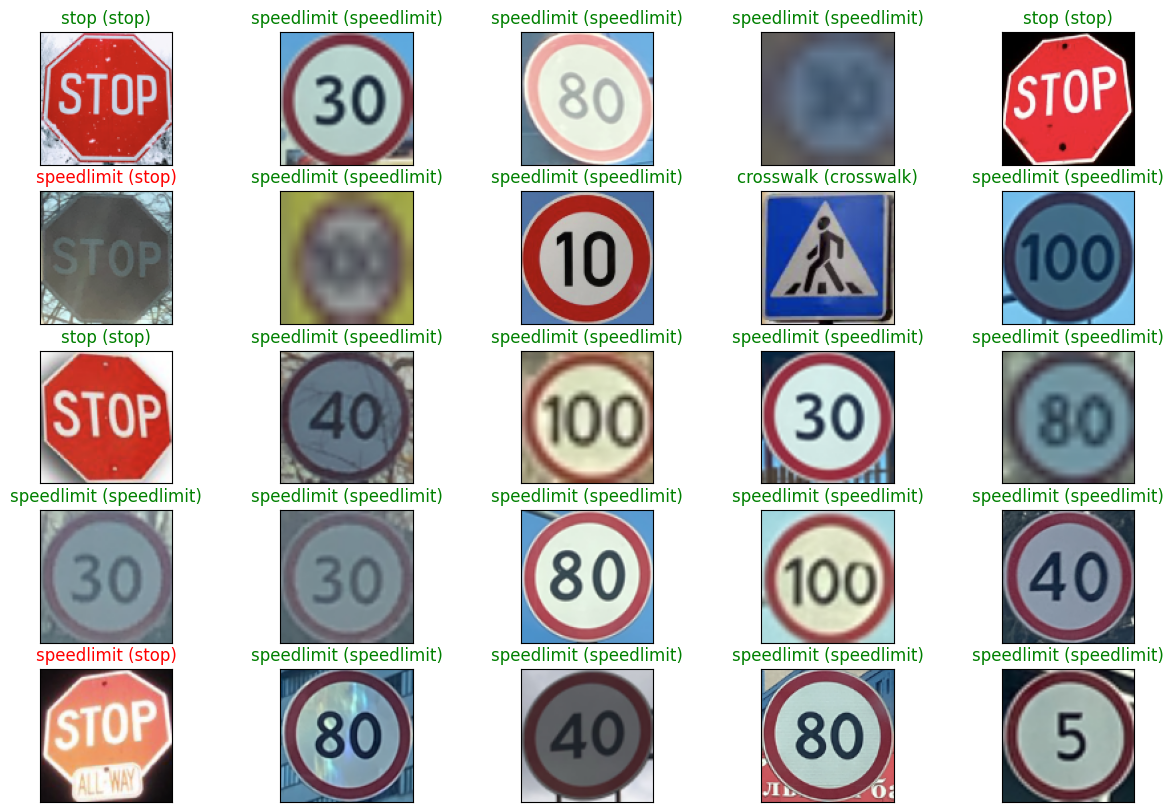

In [15]:
figure = plt.figure(figsize=(15, 10))
for i, index in enumerate(np.random.choice(x_test.shape[0], size=25, replace=False)):
    ax = figure.add_subplot(5, 5, i + 1, xticks=[], yticks=[])
    # Mostrar la imagenes elegidas al azar del conjunto de validacion
    ax.imshow(np.squeeze(x_test[index]),cmap = plt.cm.gray)
    predict_index = np.argmax(y_hat[index])
    true_index = np.argmax(y_valid[index])
    # Establecer el titulo para cada imagen
    ax.set_title("{} ({})".format(class_names[predict_index], 
                                  class_names[true_index]),
                                  color=("green" if predict_index == true_index else "red"))

Continuando con la evaluación visual del modelo, hemos construido una función interactiva para revisar una por una las imágenes del conjunto de validación.

In [16]:
def predict_image(index):
    # Obtener la imagen del conjunto de prueba según el índice dado
    image = x_test[index]

    # Agregar una dimensión adicional para el tamaño del lote (batch size)
    imageToModel = np.expand_dims(image, axis=0)

    # Realizar la predicción con el modelo
    realPredict = model.predict(imageToModel)

    # Mostrar la imagen utilizando imshow
    plt.imshow(image)
    plt.axis('off')  # Para ocultar los ejes
    plt.show()

    # Obtener el índice de la clase predicha
    predict_index = np.argmax(realPredict)
    
    # Obtener el nombre de la clase predicha
    predicted_class = class_names[predict_index]

    # Imprimir la clase predicha
    print("Clase predicha:", predicted_class)

# Utilizar la función interact para variar el índice de la imagen
interact(predict_image, index=(0, 175, 1))

interactive(children=(IntSlider(value=87, description='index', max=175), Output()), _dom_classes=('widget-inte…

<function __main__.predict_image(index)>

**Prueba Final**

Ahora, con el objetivo de evaluar el modelo de manera más realista, hemos tomado una fotografía de una señal de tránsito de nuestro entorno y la hemos cargado en el modelo entrenado. De esta manera, podemos evaluar su rendimiento con mayor criterio. A continuación, presentamos este proceso.

1/1 [==============================] - 0s 42ms/step


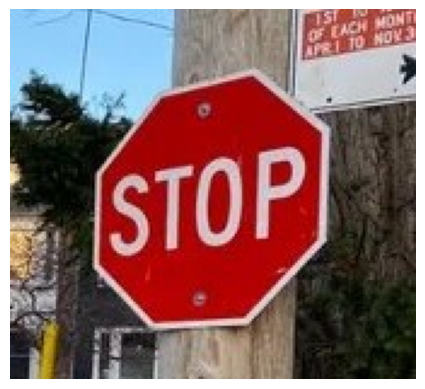

Clase predicha: stop


In [17]:
# Leer la imagen en color (RGB)
image = cv2.imread("/content/road-sign-detection/realImage/test.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Redimensionar la imagen
image_resized = cv2.resize(image, (100, 100))

# Normalizar la imagen
image_normalized = image_resized / 255.0

# Agregar una dimensión adicional para el tamaño del lote (batch size)
image_to_model = np.expand_dims(image_normalized, axis=0)

# Realizar la predicción con el modelo
real_predict = model.predict(image_to_model)

# Mostrar la imagen utilizando imshow
plt.imshow(image)
plt.axis('off')  # Para ocultar los ejes
plt.show()

# Obtener el índice de la clase predicha
predict_index = np.argmax(real_predict)

# Obtener el nombre de la clase predicha
predicted_class = class_names[predict_index]

# Imprimir la clase predicha
print("Clase predicha:", predicted_class)

**Conclusion**

Como podemos observar después de realizar las pruebas y análisis, el modelo está generalizando correctamente y puede ser utilizado de manera efectiva en situaciones del mundo real. Sin embargo, es importante destacar que para obtener una clasificación precisa, es necesario proporcionar al modelo imágenes recortadas con el objeto de interés. Si se le presenta una imagen demasiado general, el modelo puede no clasificar correctamente, ya que no fue entrenado para esa situación específica.

Estos resultados respaldan la eficacia del modelo entrenado y demuestran su capacidad para clasificar señales de tráfico con precisión. Es especialmente relevante destacar que el modelo fue entrenado en un dataset con clases desequilibradas, lo cual lo hace aún más impresionante. La métrica F1 score también respalda estos resultados, ya que muestra un buen equilibrio entre precisión y exhaustividad en la clasificación de las clases del dataset.

# __________________________________________________________

# Enfoque de extracción manual de caracteristicas

Ahora nos planteamos el reto de llevar a cabo el entrenamiento de un modelo en el cual se deba construir el conjuntos de caracteristicas manualmente.

Inicialmente vamos a calcular y almacenar el histograma de color de cada una de las imagenes ya recortadas del dataset

# 1. Histograma

In [156]:
# # Ruta del archivo CSV de salida
# csv_file = '/content/featureSet.csv'

# # Verificar si el archivo CSV ya existe
# if os.path.isfile(csv_file):
#     # Si el archivo existe, carga el DataFrame existente
#     df = pd.read_csv(csv_file)
# else:
#     # Si el archivo no existe, crea un nuevo DataFrame vacío
#     df = pd.DataFrame(columns=['histogram', 'image_file', 'label'])

# # Iterar sobre los archivos de imágenes recortadas
# for file in os.listdir(output_folder):
#     if file.endswith('.png'):
#         image_path = os.path.join(output_folder, file)
#         image = cv2.imread(image_path)
#         image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

#         if image is not None:
#             # Calcular el histograma de color
#             hist = cv2.calcHist([image], [0], None, [256], [0, 256])
#             hist_normalized = hist.flatten() / hist.sum()

#             # Obtener el nombre base del archivo sin la extensión
#             file_base = os.path.splitext(file)[0]

#             # Ruta del archivo XML correspondiente
#             xml_file = os.path.join(anno_path, file_base + '.xml')

#             if os.path.isfile(xml_file):
#                 # Procesar el archivo XML y obtener la etiqueta
#                 tree = ET.parse(xml_file)
#                 root = tree.getroot()
#                 label = root.find('object').find('name').text

#                 # Crear un nuevo DataFrame con la fila actual
#                 new_row = pd.DataFrame({'histogram': [hist_normalized.tolist()], 'image_file': [file], 'label': [label]})

#                 # Concatenar el nuevo DataFrame con el DataFrame existente
#                 df = pd.concat([df, new_row], ignore_index=True)

#                 # Guardar el DataFrame en el archivo CSV después de cada cálculo
#                 df.to_csv(csv_file, index=False, sep='|')
#             else:
#                 print(f"El archivo XML correspondiente no se encuentra: {xml_file}")
#         else:
#             print(f"Error al leer la imagen: {file}")

# print('Proceso completado.')

In [253]:
# # Ruta del archivo CSV de salida
# csv_file = '/content/featureSet.csv'

# # Verificar si el archivo CSV ya existe
# if os.path.isfile(csv_file):
#     # Si el archivo existe, carga el DataFrame existente
#     df = pd.read_csv(csv_file)
# else:
#     # Si el archivo no existe, crea un nuevo DataFrame vacío
#     df = pd.DataFrame(columns=['histogram', 'image_file', 'label', 'sum_R', 'sum_G', 'sum_B'])

# # Iterar sobre los archivos de imágenes recortadas
# for file in os.listdir(output_folder):
#     if file.endswith('.png'):
#         image_path = os.path.join(output_folder, file)
#         image = cv2.imread(image_path)
#         image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

#         if image is not None:
#             # Calcular el histograma de color
#             hist = cv2.calcHist([image], [0], None, [256], [0, 256])
#             hist_normalized = hist.flatten() / hist.sum()

#             # Calcular las sumas de los valores del histograma normalizado para cada canal de color
#             sum_R = np.sum(hist_normalized[:84])
#             sum_G = np.sum(hist_normalized[84:168])
#             sum_B = np.sum(hist_normalized[168:])

#             # Obtener el nombre base del archivo sin la extensión
#             file_base = os.path.splitext(file)[0]

#             # Ruta del archivo XML correspondiente
#             xml_file = os.path.join(anno_path, file_base + '.xml')

#             if os.path.isfile(xml_file):
#                 # Procesar el archivo XML y obtener la etiqueta
#                 tree = ET.parse(xml_file)
#                 root = tree.getroot()
#                 label = root.find('object').find('name').text

#                 # Crear un nuevo DataFrame con la fila actual
#                 new_row = pd.DataFrame({'histogram': [hist_normalized.tolist()], 'image_file': [file], 'label': [label], 'sum_R': [sum_R], 'sum_G': [sum_G], 'sum_B': [sum_B]})

#                 # Concatenar el nuevo DataFrame con el DataFrame existente
#                 df = pd.concat([df, new_row], ignore_index=True)

#                 # Guardar el DataFrame en el archivo CSV después de cada cálculo
#                 df.to_csv(csv_file, index=False, sep='|')
#             else:
#                 print(f"El archivo XML correspondiente no se encuentra: {xml_file}")
#         else:
#             print(f"Error al leer la imagen: {file}")

# print('Proceso completado.')

Proceso completado.


In [261]:
# Ruta del archivo CSV de salida
csv_file = '/content/featureSet.csv'

# Verificar si el archivo CSV ya existe
if os.path.isfile(csv_file):
    # Si el archivo existe, carga el DataFrame existente
    df = pd.read_csv(csv_file)
else:
    # Si el archivo no existe, crea un nuevo DataFrame vacío
    df = pd.DataFrame(columns=['histogram', 'image_file', 'label', 'sum_R', 'sum_G', 'sum_B'])

# Contador de imágenes de la clase "speedlimit"
speedlimit_count = 0


# Iterar sobre los archivos de imágenes recortadas
for file in os.listdir(output_folder):
    if file.endswith('.png'):
        image_path = os.path.join(output_folder, file)
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        if image is not None:
            # Calcular el histograma de color
            hist = cv2.calcHist([image], [0], None, [256], [0, 256])
            hist_normalized = hist.flatten() / hist.sum()

            # Calcular las sumas de los valores del histograma normalizado para cada canal de color
            sum_R = np.sum(hist_normalized[:84])
            sum_G = np.sum(hist_normalized[84:168])
            sum_B = np.sum(hist_normalized[168:])

            # Obtener el nombre base del archivo sin la extensión
            file_base = os.path.splitext(file)[0]

            # Ruta del archivo XML correspondiente
            xml_file = os.path.join(anno_path, file_base + '.xml')

            if os.path.isfile(xml_file):
                # Procesar el archivo XML y obtener la etiqueta
                tree = ET.parse(xml_file)
                root = tree.getroot()
                label = root.find('object').find('name').text

                if label == 'speedlimit':
                    if speedlimit_count < 60:
                        speedlimit_count += 1
                    else:
                        continue  # Ignorar imágenes adicionales de speedlimit

                # Crear un nuevo DataFrame con la fila actual
                new_row = pd.DataFrame({'histogram': [hist_normalized.tolist()], 'image_file': [file], 'label': [label], 'sum_R': [sum_R], 'sum_G': [sum_G], 'sum_B': [sum_B]})

                # Concatenar el nuevo DataFrame con el DataFrame existente
                df = pd.concat([df, new_row], ignore_index=True)

                # Guardar el DataFrame en el archivo CSV después de cada cálculo
                df.to_csv(csv_file, index=False, sep='|')
            else:
                print(f"El archivo XML correspondiente no se encuentra: {xml_file}")
        else:
            print(f"Error al leer la imagen: {file}")

print('Proceso completado.')

Proceso completado.


Ahora procederemos a graficar el histograma de algunas imagenes seleccionadas al azar para cada tipo de etiqueta en el dataset. Esto nos permitirá validar si existen diferencias notables en la distribución de colores entre las distintas clases.

In [262]:
df.head()

,histogram,image_file,label,sum_R,sum_G,sum_B
0,"[0.002099999925121665, 0.0006000000284984708, ...",road17.png,trafficlight,0.3098,0.4080,0.2822
1,"[0.0, 0.0008999999845400453, 0.001000000047497...",road156.png,crosswalk,0.4946,0.2294,0.2760
2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",road670.png,speedlimit,0.2193,0.4470,0.3337
3,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",road141.png,crosswalk,0.4842,0.0938,0.4220
4,"[0.01510000042617321, 0.01979999989271164, 0.0...",road41.png,trafficlight,0.1840,0.1659,0.6501


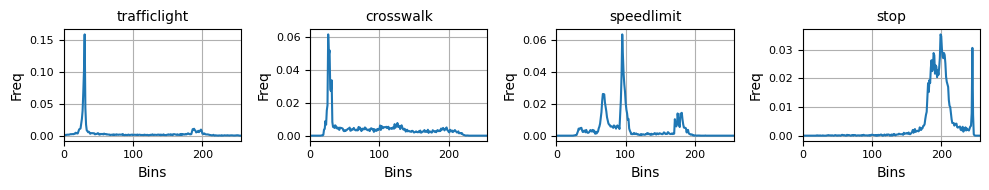

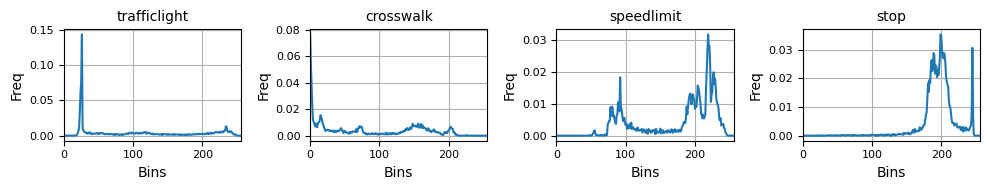

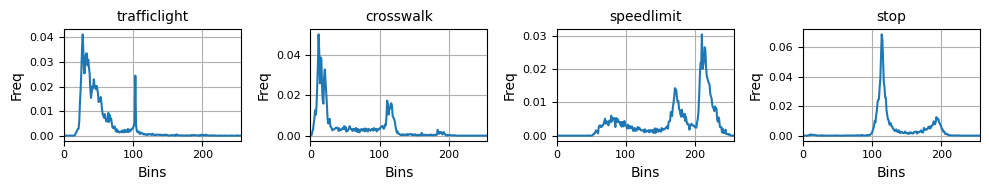

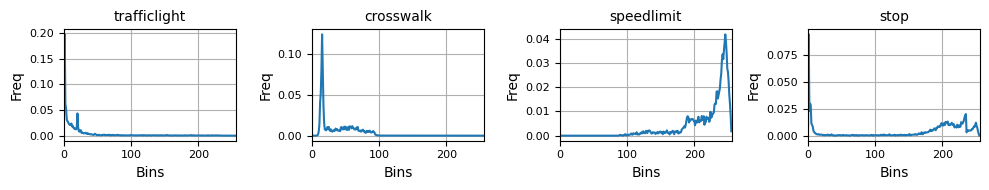

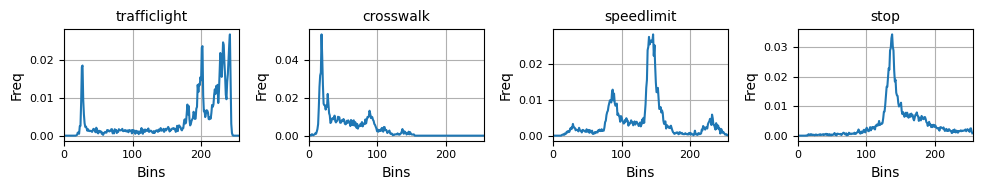

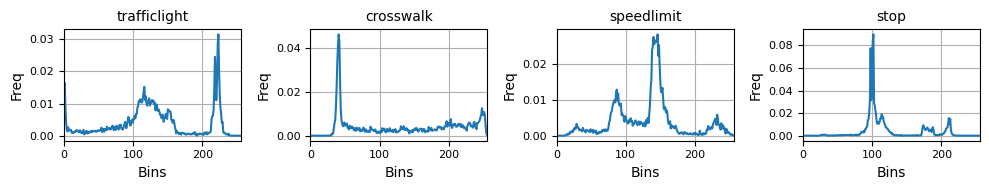

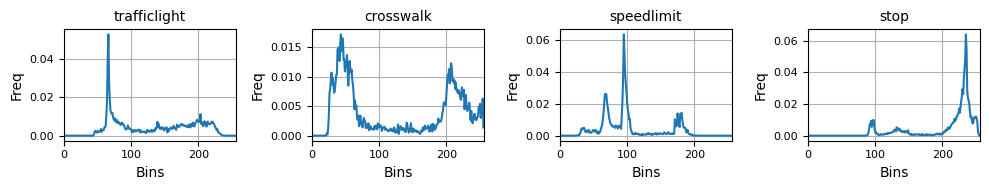

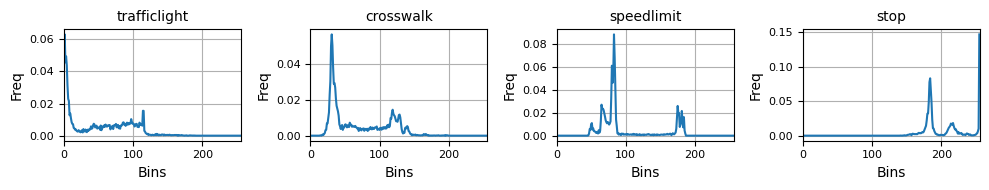

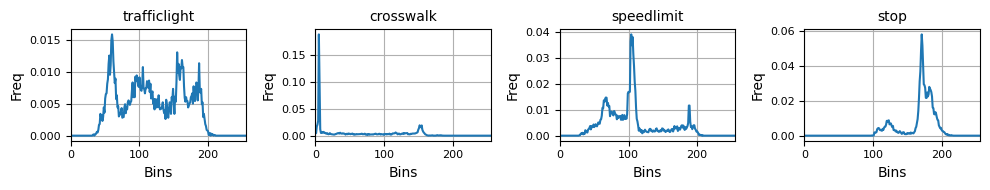

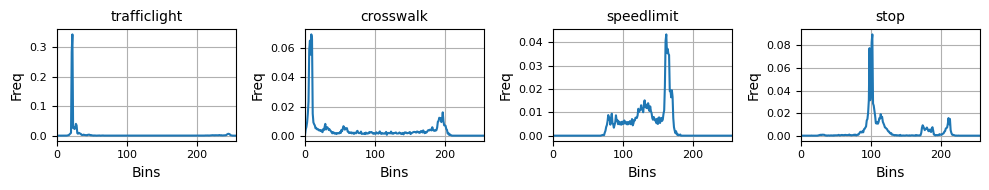

In [263]:
# Obtener las clases únicas
classes = df['label'].unique()

# Calcular el número de subgráficos por fila
num_subplots = len(classes)

for i in range(10):
  # Configurar el tamaño de la figura y el tamaño de cada subgráfico
  fig, axs = plt.subplots(1, num_subplots, figsize=(10, 2))

  # Iterar sobre las clases
  for i, class_name in enumerate(classes):
    
      # Filtrar el DataFrame por la clase actual
      class_df = df[df['label'] == class_name]

      # Obtener un índice aleatorio
      random_index = np.random.randint(0, len(class_df))

      # Obtener el histograma y el nombre del archivo aleatorio
      histogram_str = class_df.iloc[random_index]['histogram']
      # print(histogram_str)  # Imprimir el valor de histogram_str
      histogram = [float(i) for i in histogram_str]
      image_file = class_df.iloc[random_index]['image_file']

      # Generar los valores x para el histograma
      x = np.arange(len(histogram))

      # Graficar el histograma en el subgráfico correspondiente
      axs[i].plot(x, histogram)

      # Configurar los límites del eje x
      axs[i].set_xlim([0, len(histogram)])

      # Reducir el tamaño de la fuente del título
      axs[i].set_title(f'{class_name}', fontsize=10)
      axs[i].set_xlabel('Bins')
      axs[i].set_ylabel('Freq')

      # Graficamos la cuadrícula con un espaciado más denso
      axs[i].grid()

      # Reducir el tamaño de la fuente de los labels de los ejes
      axs[i].tick_params(axis='both', labelsize=8)

  # Ajustar el espaciado entre subgráficos
  plt.tight_layout()

  # Mostrar la figura
  plt.show()


En los diferentes histogramas se pueden apreciar ciertos patrones en cada grupo. Por ejemplo, en los semáforos se observa que hay una concentración de muchos píxeles en tonalidades cercanas al negro. Esto es de esperar, ya que en estos elementos tenemos la cobertura total de las luces predominando, y luego solo alguna de las tres luces encendidas.

Para las señales de límite de velocidad, se puede observar comúnmente la presencia de 2 picos de intensidad en el histograma. Estos patrones característicos pueden deberse a la presencia de elementos distintivos en las señales, como números o símbolos de límites de velocidad.

Cada grupo en el dataset tiene sus propios patrones característicos en los histogramas, lo que refleja las diferencias en la distribución de colores y la intensidad en cada tipo de señal de tráfico. Estos patrones pueden ser útiles para la detección y clasificación automática de las señales de tráfico en futuros modelos y algoritmos.

Calcular el histograma de una imagen es un paso importante en el proceso de detección de señales de tráfico utilizando el dataset de Road Sign Detection de Kaggle. El histograma de una imagen representa la distribución de los valores de los píxeles en la imagen. Proporciona información sobre la intensidad y la frecuencia de aparición de diferentes niveles de gris o colores en la imagen.

Aquí hay algunas razones por las que el cálculo del histograma es útil para el ejercicio de detección de señales de tráfico:

**Características distintivas**: Las señales de tráfico suelen tener características visuales específicas, como formas, colores y patrones. El histograma puede capturar estas características distintivas mediante la representación de la distribución de los valores de píxeles relacionados con esas características. Esto permite identificar patrones de intensidad o color que son típicos de las señales de tráfico.

**Normalización de iluminación**: Las condiciones de iluminación pueden variar en las imágenes de señales de tráfico. El cálculo del histograma permite normalizar la iluminación, lo que implica igualar la distribución de los niveles de gris o colores en la imagen. Esto ayuda a reducir la variabilidad causada por diferentes condiciones de iluminación y facilita la detección de características relevantes.

**Comparación y clasificación**: El histograma proporciona una representación compacta de las características visuales de una imagen. Al calcular el histograma de las imágenes de señales de tráfico en el dataset, se obtiene una representación numérica de cada imagen. Esto facilita la comparación y clasificación de las imágenes utilizando técnicas de análisis de patrones y aprendizaje automático. Puedes medir la similitud o la diferencia entre los histogramas de diferentes imágenes para determinar si pertenecen a la misma clase o no.

**Eficiencia computacional**: El histograma es una representación reducida de la información visual de una imagen. En lugar de trabajar con la imagen completa, puedes trabajar con su histograma, lo que puede ser computacionalmente más eficiente. Esto es especialmente beneficioso cuando se manejan grandes volúmenes de datos, como en el caso de un dataset de detección de señales de tráfico con muchas imágenes.

# 2. Bordes y Areas

Número de bordes: 5416
Área total de los bordes: 1381080.0


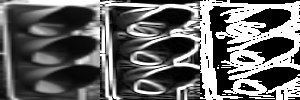

Número de bordes: 4511
Área total de los bordes: 1150305.0


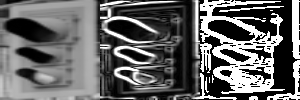

Número de bordes: 5153
Área total de los bordes: 1314015.0


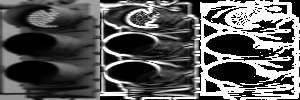

Número de bordes: 2810
Área total de los bordes: 716550.0


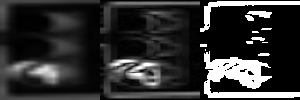

Número de bordes: 3254
Área total de los bordes: 829770.0


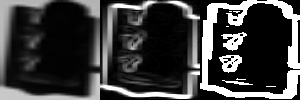

Número de bordes: 4128
Área total de los bordes: 1052640.0


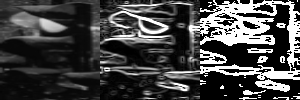

Número de bordes: 3175
Área total de los bordes: 809625.0


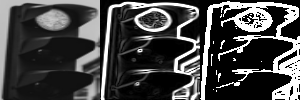

Número de bordes: 5435
Área total de los bordes: 1385925.0


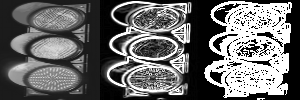

Número de bordes: 4698
Área total de los bordes: 1197990.0


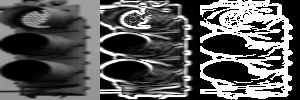

Número de bordes: 2580
Área total de los bordes: 657900.0


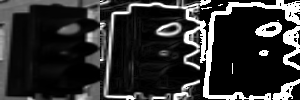

Número de bordes: 4913
Área total de los bordes: 1252815.0


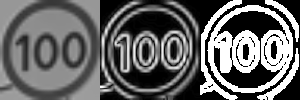

Número de bordes: 4168
Área total de los bordes: 1062840.0


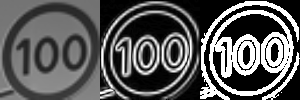

Número de bordes: 5714
Área total de los bordes: 1457070.0


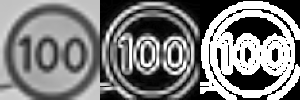

Número de bordes: 4983
Área total de los bordes: 1270665.0


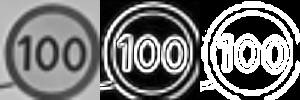

Número de bordes: 4442
Área total de los bordes: 1132710.0


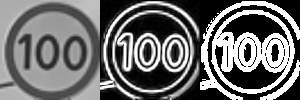

In [264]:
for i in range(15):
  # Cargar la imagen en escala de grises
  imagen = cv2.imread(f'/content/road-sign-detection/cropped_images/road4{i}.png', cv2.IMREAD_GRAYSCALE)

  # Aplicar el operador Sobel
  sobelx = cv2.Sobel(imagen, cv2.CV_64F, 1, 0, ksize=3)
  sobely = cv2.Sobel(imagen, cv2.CV_64F, 0, 1, ksize=3)

  # Calcular el gradiente total
  gradiente = np.sqrt(sobelx**2 + sobely**2)

  # Aplicar un umbral para binarizar la imagen del gradiente
  umbral = 50
  _, binarizada = cv2.threshold(gradiente, umbral, 255, cv2.THRESH_BINARY)

  # Calcular el número de bordes
  num_bordes = np.count_nonzero(binarizada)  # Cuenta los píxeles diferentes de cero

  # Calcular el área total de los bordes
  area_bordes = np.sum(binarizada)  # Suma los valores de los píxeles

  # Imprimir las características
  print("Número de bordes:", num_bordes)
  print("Área total de los bordes:", area_bordes)

  # Mostrar las tres imágenes en una ventana
  resultados = np.hstack((imagen, gradiente, binarizada))
  cv2_imshow(resultados)

In [265]:
# Leer el archivo CSV que contiene los nombres de las imágenes
data = pd.read_csv(csv_file, sep='|')  # Reemplaza 'ruta_del_archivo.csv' con la ruta adecuada

# Crear una lista para almacenar los resultados
resultados = []

# Iterar sobre las filas del DataFrame
for index, row in data.iterrows():
  # Obtener el nombre de la imagen
  imagen_nombre = row['image_file']  # Reemplaza 'Nombre de la imagen' con la columna adecuada

  # Cargar la imagen en escala de grises
  imagen = cv2.imread(f'/content/road-sign-detection/cropped_images/{imagen_nombre}', cv2.IMREAD_GRAYSCALE)

  # Aplicar el operador Sobel
  sobelx = cv2.Sobel(imagen, cv2.CV_64F, 1, 0, ksize=3)
  sobely = cv2.Sobel(imagen, cv2.CV_64F, 0, 1, ksize=3)

  # Calcular el gradiente total
  gradiente = np.sqrt(sobelx**2 + sobely**2)

  # Aplicar un umbral para binarizar la imagen del gradiente
  umbral = 50
  _, binarizada = cv2.threshold(gradiente, umbral, 255, cv2.THRESH_BINARY)

  # Calcular el número de bordes
  num_bordes = np.count_nonzero(binarizada)  # Cuenta los píxeles diferentes de cero

  # Calcular el área total de los bordes
  area_bordes = np.sum(binarizada)  # Suma los valores de los píxeles

  # Agregar los resultados a la lista
  resultados.append({'Imagen': imagen_nombre, 'Num_Bordes': num_bordes, 'Area_Bordes': area_bordes})

# Crear un DataFrame a partir de la lista de resultados
resultados_df = pd.DataFrame(resultados)

# Combinar los DataFrames utilizando la columna "image_file" como clave
combined_df = pd.concat([data, resultados_df], axis=1)

resultados_df.head()

,Imagen,Num_Bordes,Area_Bordes
0,road17.png,5981,1525155.0
1,road156.png,3550,905250.0
2,road670.png,4207,1072785.0
3,road141.png,4766,1215330.0
4,road41.png,4511,1150305.0


In [266]:
combined_df.head()

,histogram,image_file,label,sum_R,sum_G,sum_B,Imagen,Num_Bordes,Area_Bordes
0,"[0.002099999925121665, 0.0006000000284984708, ...",road17.png,trafficlight,0.3098,0.4080,0.2822,road17.png,5981,1525155.0
1,"[0.0, 0.0008999999845400453, 0.001000000047497...",road156.png,crosswalk,0.4946,0.2294,0.2760,road156.png,3550,905250.0
2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",road670.png,speedlimit,0.2193,0.4470,0.3337,road670.png,4207,1072785.0
3,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",road141.png,crosswalk,0.4842,0.0938,0.4220,road141.png,4766,1215330.0
4,"[0.01510000042617321, 0.01979999989271164, 0.0...",road41.png,trafficlight,0.1840,0.1659,0.6501,road41.png,4511,1150305.0


In [267]:
# Guardar los resultados en un nuevo archivo CSV
combined_df[['image_file', 'histogram', 'sum_R', 'sum_G', 'sum_B', 'Num_Bordes', 'Area_Bordes', 'label']].to_csv(csv_file, sep='|', index=False)

Hasta este punto hemos aplicado sobel y binarizado la imagen, contamos la cantidad de pixeles diferentes de cero y los sumamos generando dos columnas mas Num_Bordes y Area_Bordes, esto debido a que al aplicar el operador Sobel, obtenemos una imagen donde los píxeles que representan los bordes tienen un valor diferente de cero ya que los bordes se destacan como transiciones bruscas en los valores de intensidad de la imagen.




La extracción de contornos en el contexto del desarrollo de una aplicación de algoritmo de aprendizaje supervisado para la detección de señales de tráfico puede ser importante por varias razones:

Características discriminativas: Los contornos proporcionan información sobre la forma y estructura de los objetos en una imagen. En el caso de las señales de tráfico, cada señal tiene una forma y patrón de contorno característico. Al extraer los contornos de las imágenes del conjunto de datos, puedes capturar estas características distintivas que ayudarán al algoritmo a reconocer y distinguir diferentes tipos de señales de tráfico.

Reducción de dimensionalidad: Las imágenes en un conjunto de datos suelen ser de alta dimensionalidad debido a su tamaño y resolución. Al extraer los contornos, puedes reducir la dimensionalidad de los datos. En lugar de trabajar con imágenes completas, puedes representar cada imagen mediante los contornos extraídos, lo que reduce la complejidad del problema y puede facilitar el proceso de entrenamiento del algoritmo.

Robustez ante variaciones: Los contornos tienden a ser menos sensibles a variaciones en la iluminación, el color y otros factores que pueden afectar la apariencia global de una imagen. Al centrarse en la información de contorno, puedes lograr una mayor robustez del algoritmo frente a estas variaciones, lo que ayuda a mejorar la precisión del sistema de detección de señales de tráfico en diferentes condiciones.

Eficiencia computacional: Los contornos suelen ser representaciones más simples y compactas en comparación con las imágenes originales. Al utilizar los contornos en lugar de las imágenes completas, puedes reducir la carga computacional necesaria para procesar los datos, lo que puede llevar a un mejor rendimiento y tiempos de ejecución más rápidos.

En resumen, la extracción de contornos de las imágenes del conjunto de datos puede proporcionar características discriminativas, reducir la dimensionalidad, mejorar la robustez ante variaciones y optimizar la eficiencia computacional del algoritmo de aprendizaje supervisado para la detección de señales de tráfico.

Color: Puedes extraer información de color de las imágenes, como histogramas de color, valores de intensidad promedio o características cromáticas específicas para detectar patrones relacionados con las señales de tránsito.

Forma: Puedes utilizar algoritmos de detección de contornos para identificar formas y estructuras relevantes en las imágenes. Por ejemplo, puedes buscar formas circulares, triangulares, octogonales, etc., que sean características de ciertos tipos de señales de tránsito.

Textura: Puedes analizar la textura de las imágenes para buscar patrones de textura característicos de las señales de tránsito. Esto puede incluir características como bordes, gradientes, patrones repetitivos, etc.

Características geométricas: Puedes extraer características geométricas, como la relación de aspecto, el área, la ubicación y la orientación de las señales de tránsito dentro de la imagen.

Descriptores de puntos clave: Puedes utilizar algoritmos de detección de puntos clave, como SIFT, SURF o ORB, para identificar puntos clave en las imágenes y describir sus características locales. Estos descriptores pueden ayudar a identificar las características distintivas de las señales de tránsito.

Redes neuronales convolucionales (CNN): Puedes utilizar arquitecturas de CNN pre-entrenadas, como VGG, ResNet o Inception, y extraer características de alto nivel de las capas convolucionales para alimentarlas al modelo. Estas características aprendidas pueden capturar información importante en las imágenes relacionada con las señales de tránsito.

# Visualización de caracteristicas

In [268]:
# Leer el archivo CSV resultante
data = pd.read_csv(csv_file, sep='|')

data.head()

,image_file,histogram,sum_R,sum_G,sum_B,Num_Bordes,Area_Bordes,label
0,road17.png,"[0.002099999925121665, 0.0006000000284984708, ...",0.3098,0.4080,0.2822,5981,1525155.0,trafficlight
1,road156.png,"[0.0, 0.0008999999845400453, 0.001000000047497...",0.4946,0.2294,0.2760,3550,905250.0,crosswalk
2,road670.png,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.2193,0.4470,0.3337,4207,1072785.0,speedlimit
3,road141.png,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.4842,0.0938,0.4220,4766,1215330.0,crosswalk
4,road41.png,"[0.01510000042617321, 0.01979999989271164, 0.0...",0.1840,0.1659,0.6501,4511,1150305.0,trafficlight


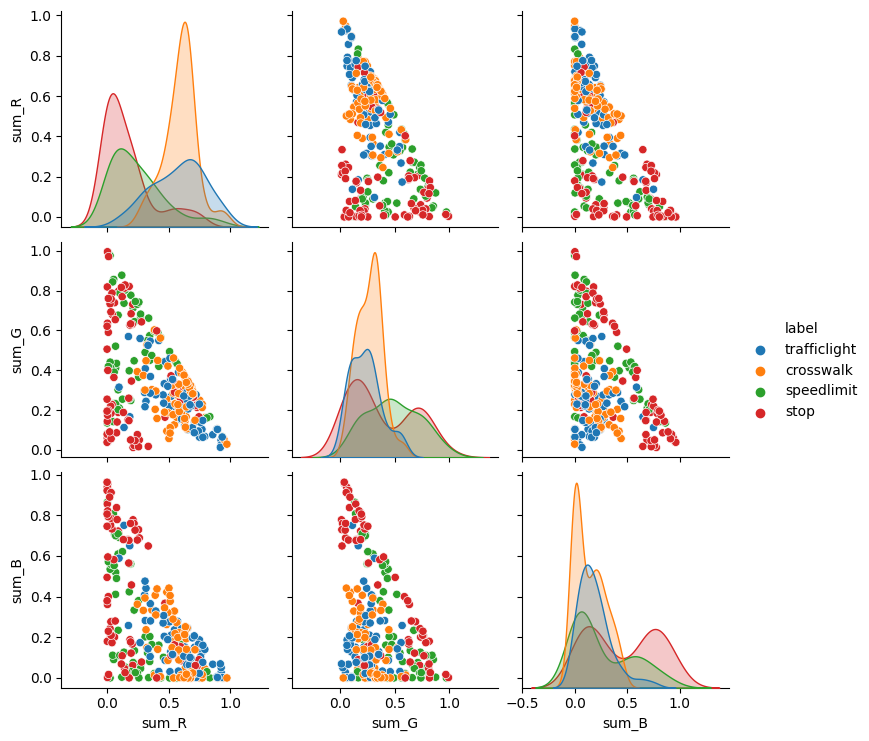

In [269]:
# Seleccionar las columnas relevantes para el pairplot
#columns = ['label', 'Num_Bordes', 'Area_Bordes', 'sum_R', 'sum_G', 'sum_B']
columns = ['label', 'sum_R', 'sum_G', 'sum_B']

# Crear el pairplot
sns.pairplot(data[columns], hue='label')

# Mostrar el gráfico
plt.show()

In [280]:
# Dividir el dataset en características (X) y etiquetas (y)
#X = data.drop(['label', 'image_file'], axis=1)
#X = data[['Num_Bordes', 'Area_Bordes', 'sum_R', 'sum_G', 'sum_B']]
X = data[['sum_R', 'sum_G', 'sum_B']]
y = data['label']

# Crear una instancia del codificador
label_encoder = LabelEncoder()

# Codificar las etiquetas
y_encoded = label_encoder.fit_transform(y)

# Dividir en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.3, random_state=42)

In [281]:
# Crear una instancia de la SVM
svm = SVC()

# Entrenar la SVM
svm.fit(X_train, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred = svm.predict(X_test)

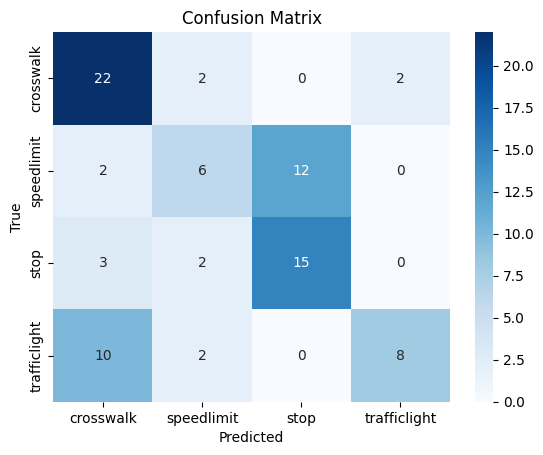

0.5930232558139535

In [282]:
# Obtener la matriz de confusión
cm = confusion_matrix(y_test, y_pred)

# Obtener las etiquetas de las clases
class_labels = label_encoder.classes_

# Crear un heatmap de la matriz de confusión
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=class_labels, yticklabels=class_labels)

# Configurar etiquetas y título
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')

# Mostrar el gráfico
plt.show()

accuracy_score(y_test,y_pred)

In [283]:
# Entrenar el clasificador de Regresión Logística
clfLR = LogisticRegression(random_state=0)
clfLR.fit(X_train, y_train) # para entrenar enviamos el conjunto de Entrenamient

LogisticRegression(random_state=0)

In [284]:
# Luego realizamos predicciones de los modelos
yPredTest_LR= clfLR.predict(X_test)

accTest_LR = accuracy_score(y_test,yPredTest_LR)

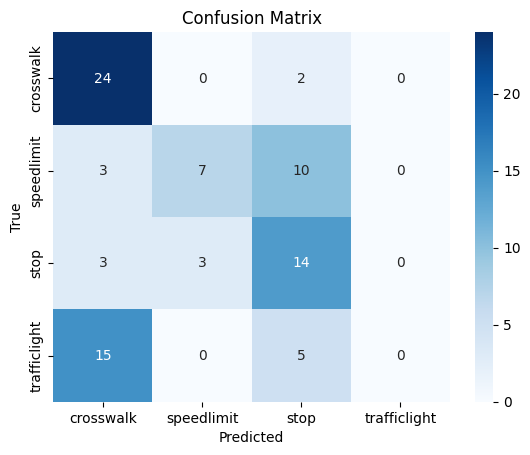

0.5232558139534884

In [285]:
# Obtener la matriz de confusión
cm = confusion_matrix(y_test, yPredTest_LR)

# Obtener las etiquetas de las clases
class_labels = label_encoder.classes_

# Crear un heatmap de la matriz de confusión
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=class_labels, yticklabels=class_labels)

# Configurar etiquetas y título
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')

# Mostrar el gráfico
plt.show()

accuracy_score(y_test,yPredTest_LR)

1. Support Vector Machines (SVM): SVM es un algoritmo que se utiliza comúnmente para problemas de clasificación. Su objetivo principal es encontrar un hiperplano en un espacio dimensional superior que pueda separar de manera óptima las diferentes clases de datos. En el contexto de reconocimiento de señales de tráfico, SVM puede ser efectivo para clasificar las diferentes señales en categorías específicas.

2. Random Forest: Random Forest es un algoritmo de aprendizaje en conjunto que combina múltiples árboles de decisión para realizar la clasificación. Cada árbol en el bosque se entrena con una muestra aleatoria de datos y produce una clasificación. Luego, el resultado final se determina por votación o promediando las predicciones de los árboles individuales. Random Forest es conocido por su eficacia y su capacidad para manejar características de alta dimensionalidad, lo que puede ser útil en el reconocimiento de señales de tráfico donde las características pueden ser diversas.